# Решение по предсказанию успеха проекта на kickstarter.com

## Подключение к Google диску

In [ ]:
pip install google-colab

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/DANO_2021

kickstarter_data.csv  val.csv


## Подключаем библиотеки

In [ ]:
import matplotlib
matplotlib.use("Agg")

# подключаем необходимые пакеты
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os
from keras.layers.core import Dropout
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

## Настройка Seaborn графиков

In [ ]:
sns.set_style(style='white') 
sns.set(rc={
    'figure.figsize':(12,7), 
    'axes.facecolor': 'white',
    'axes.grid': True, 'grid.color': '.9',
    'axes.linewidth': 1.0,
    'grid.linestyle': u'-'},font_scale=1.5)
custom_colors = ["#3498db", "#95a5a6","#34495e", "#2ecc71", "#e74c3c"]
sns.set_palette(custom_colors)

## Какие данные присутствуют в таблице

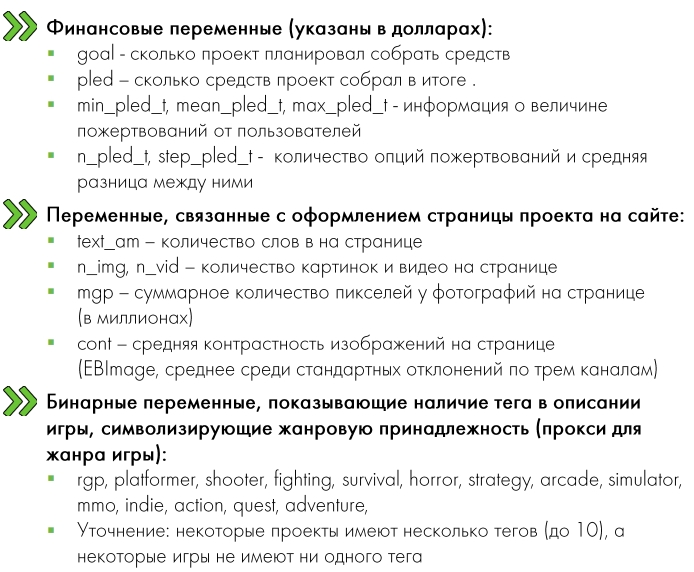

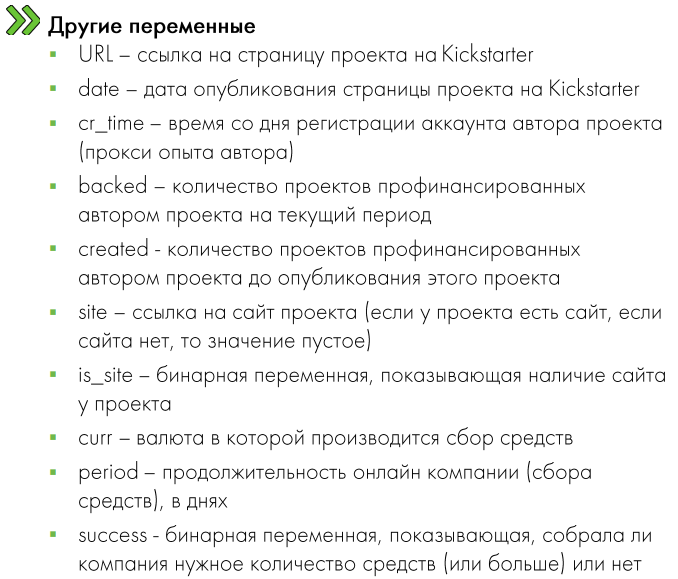

## Загрузка датасетов и предобработка

### Загружаем data и удаляем ненужные столбцы с данными

In [434]:
tb = pd.read_csv("/content/drive/MyDrive/DANO_2021/kickstarter_data.csv")

tb = tb.drop('URL', 1) # удаляем ссылку
tb = tb.drop('date', 1) # удаляем дату публикования
tb = tb.drop('curr', 1) # удаляем валюту, нужно переработать переводить все деньги в евро
tb = tb.drop('mgp', 1) # удаляем количество пикселей фото
tb = tb.drop('cont', 1) # удаляем контрастность фото
tb = tb.drop('site', 1) # удаляем ссылку на проект
tb = tb.drop('status', 1) # удаляем статус заявки

tb = tb.drop('backed', 1) # удаляем кол-во профинансированных проектов на данный момент

tb = tb.drop('min_pled_t', 1) # удаляем минимальное пожертвование
tb = tb.drop('max_pled_t', 1) # удаляем максимальное пожертвование
tb = tb.drop('mean_pled_t', 1) # удаляем средн. пожертвование


tb = tb.drop('pled', 1) # удаляем сколько проект собрал

tb = tb.drop('id', 1) # удаляем id

tb

,goal,period,text_am,n_img,n_vid,n_pled_t,step_pled_t,cr_time,created,rpg,platformer,shooter,fighting,survival,horror,strategy,arcade,simulator,mmo,indie,action,quest,adventure,success,is_site
0,16368.00,14,355,7,0,8,1168.908571,16,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,7278.02,30,2218,33,3,5,24.017500,592,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1
2,35000.00,31,3174,19,3,13,82.916667,253,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,10000.00,14,110,0,0,3,487.500000,195,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,67000.00,30,3955,46,1,15,71.357143,20,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7750,7000.00,60,912,10,0,8,141.428571,191,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
7751,15000.00,45,1650,39,2,23,363.590909,146,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
7752,10000.00,30,280,10,1,9,24.875000,703,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7753,3928.54,31,777,0,0,7,14.581667,93,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


### Загружаем val и удаляем ненужные столбцы с данными

In [435]:
val = pd.read_csv("/content/drive/MyDrive/DANO_2021/val.csv")

val = val.drop('URL', 1) # удаляем ссылку
val = val.drop('date', 1) # удаляем дату публикования
val = val.drop('curr', 1) # удаляем валюту, возможно нужно переработать переводить все деньги в евро
val = val.drop('mgp', 1) # удаляем количество пикселей фото
val = val.drop('cont', 1) # удаляем контрастность фото
val = val.drop('site', 1) # удаляем ссылку на проект
val = val.drop('status', 1) # удаляем статус заявки

val = val.drop('backed', 1) # удаляем кол-во профинансированных проектов на данный момент

val = val.drop('min_pled_t', 1) # удаляем минимальное пожертвование
val = val.drop('max_pled_t', 1) # удаляем максимальное пожертвование
val = val.drop('mean_pled_t', 1) # удаляем средн. пожертвование


val = val.drop('pled', 1) # удаляем сколько проект собрал

val = val.drop('id', 1) # удаляем id

val

,goal,period,text_am,n_img,n_vid,n_pled_t,step_pled_t,cr_time,created,rpg,platformer,shooter,fighting,survival,horror,strategy,arcade,simulator,mmo,indie,action,quest,adventure,success,is_site
0,125.00,30,418,0,0,6,5.800000,32,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
1,772.50,30,305,13,1,5,31.865000,551,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,5376.83,30,158,0,0,5,21.282500,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,825.31,31,1103,14,1,10,50.435556,21,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
4,90000.00,31,1546,16,1,11,298.500000,33,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2115,16775.00,60,136,0,0,4,9.660000,594,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2116,100000.00,30,567,0,1,4,331.666667,91,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2117,60750.00,29,369,4,0,8,1428.428571,385,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2118,21500.00,30,3508,51,0,14,38.076923,388,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1


## Формируем train и test выборку

In [437]:
train = tb.sample(frac = 0.75)
test = tb.drop(train.index).sample(frac = 0.5)

In [438]:
test.head(5)

,goal,period,text_am,n_img,n_vid,n_pled_t,step_pled_t,cr_time,created,rpg,platformer,shooter,fighting,survival,horror,strategy,arcade,simulator,mmo,indie,action,quest,adventure,success,is_site
4181,75000.0,60,401,0,0,3,45.000000,55,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7298,8000.0,30,1195,5,2,16,66.333333,252,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1
4984,7000.0,30,1043,11,0,12,89.545455,636,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5949,18000.0,27,2411,6,0,11,499.900000,743,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1
505,1800.0,30,593,12,1,9,61.875000,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1


In [439]:
train.head(5)

,goal,period,text_am,n_img,n_vid,n_pled_t,step_pled_t,cr_time,created,rpg,platformer,shooter,fighting,survival,horror,strategy,arcade,simulator,mmo,indie,action,quest,adventure,success,is_site
1156,5000.00,30,2561,37,2,13,24.916667,1156,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1
2567,38000.00,30,834,3,0,7,48.333333,24,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4505,14000.00,45,835,0,0,6,98.000000,56,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3067,23646.15,60,261,0,0,9,88.672500,180,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
163,1000.00,27,924,9,1,6,34.000000,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


## Конкатенируем данные

In [440]:
td = pd.concat([train, test], ignore_index=True, sort = False)

## Проверяем на отсутствие значений

goal           0
period         0
text_am        0
n_img          0
n_vid          0
n_pled_t       0
step_pled_t    0
cr_time        0
created        0
rpg            0
platformer     0
shooter        0
fighting       0
survival       0
horror         0
strategy       0
arcade         0
simulator      0
mmo            0
indie          0
action         0
quest          0
adventure      0
success        0
is_site        0
dtype: int64

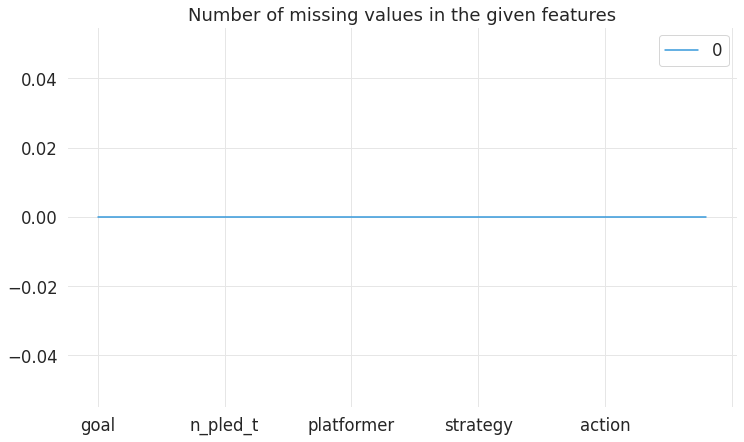

In [441]:
pd.DataFrame(td.isnull().sum()).plot.line().set_title("Number of missing values in the given features")
td.isnull().sum()

Text(0.5, 1.0, 'Missing values heatmap')

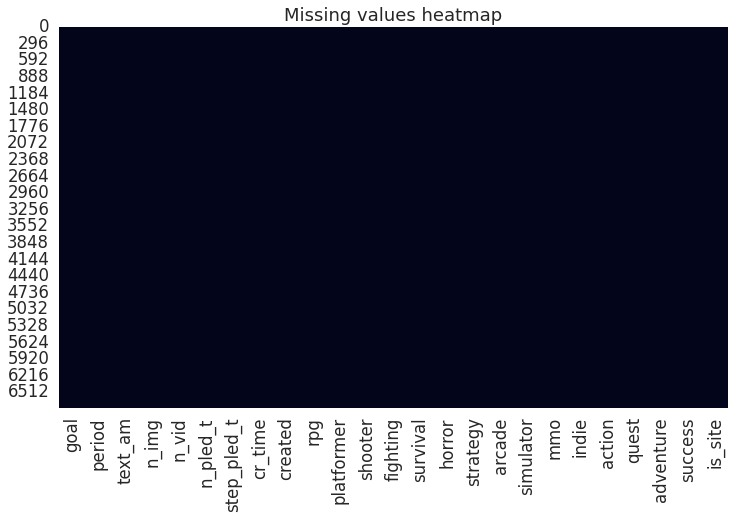

In [442]:
td.isnull().sum()
sns.heatmap(td.isnull(), cbar = False).set_title("Missing values heatmap")

## Смотрим сколько возможно различных значений по каждому столбцу

In [443]:
td.nunique()

goal           2450
period           78
text_am        2595
n_img            95
n_vid            16
n_pled_t         45
step_pled_t    3214
cr_time        1274
created          14
rpg               2
platformer        2
shooter           2
fighting          2
survival          2
horror            2
strategy          2
arcade            2
simulator         2
mmo               2
indie             2
action            2
quest             2
adventure         2
success           2
is_site           2
dtype: int64

## Вероятность успешных проектов

Text(0.5, 1.0, 'Training Data - Percentage of success projects')

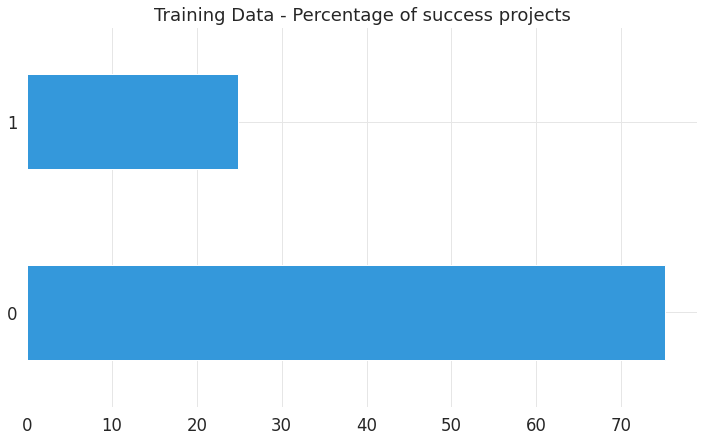

In [444]:
(train.success.value_counts(normalize=True) * 100).plot.barh().set_title("Training Data - Percentage of success projects")

## Формируем выборки для обучения

In [445]:
X_to_be_predicted = td[td.success.isnull()]
X_to_be_predicted = X_to_be_predicted.drop(['success'], axis = 1)                                          

In [446]:
train_data = td
train_data = train_data.dropna()
feature_train = train_data['success']
label_train = train_data.drop(['success'], axis = 1)

## Обучаем по алгоритму "Случайный лес" 

In [448]:
clf = RandomForestClassifier(criterion='entropy',
n_estimators=1000,
min_samples_split=10,
min_samples_leaf=1,
max_features='auto',
oob_score=True,
random_state=1,
n_jobs=-1)

In [449]:
x_train, x_test, y_train, y_test = train_test_split(label_train, feature_train, test_size=0.2)
clf.fit(x_train, np.ravel(y_train))
print("RF Accuracy: "+repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")

RF Accuracy: 85.57%


In [450]:
result_rf=cross_val_score(clf,x_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for Random forest is:',round(result_rf.mean()*100,2))

The cross validated score for Random forest is: 86.55


Text(0.5, 1.05, 'Confusion_matrix for RF')

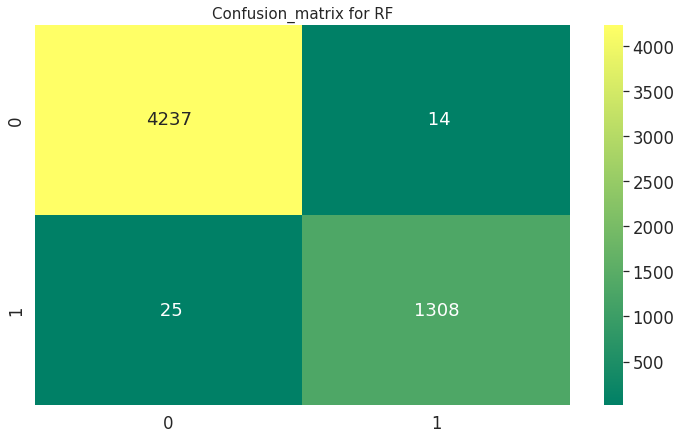

In [369]:
y_pred = cross_val_predict(clf,x_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for RF', y=1.05, size=15)

## Формируем val для проверки 

In [451]:
val1 = val
val1 = val1[['success']]
val1

,success
0,0
1,1
2,0
3,1
4,1
...,...
2115,0
2116,0
2117,0
2118,0


In [452]:
val = val.drop('success', 1)

## Предсказываем значения

In [453]:
predict = clf.predict(val)
submission = pd.DataFrame({
    "success": predict
})
#submission.to_csv("submission.csv", index=False)

In [454]:
submission

,success
0,0
1,1
2,0
3,1
4,0
...,...
2115,0
2116,0
2117,0
2118,0


## Начинаем сверять с правильными и получаем score

In [455]:
valList = val1['success'].tolist()
subList = submission['success'].tolist()

In [456]:
score = 0
for i in valList:
  if valList[i] == subList[i]:
    score +=1
score = score / submission.shape[0]
score

1.0

Попробуем посмотреть как работает нейронка на data (просто так дебаг)

In [459]:
tb_2 = tb
tb_2 = tb_2.drop('success', 1)

In [460]:
predict_2 = clf.predict(tb_2)
submission_2 = pd.DataFrame({
    "success": predict
})
#submission.to_csv("submission.csv", index=False)

In [461]:
validList = tb['success'].tolist()
submisList = submission_2['success'].tolist()

In [462]:
score = 0
for i in valList:
  if validList[i] == submisList[i]:
    score +=1
score = score / submission.shape[0]
score

1.0

## Ввод данных по проекту для предсказания

In [473]:
input = pd.DataFrame(index=[0],columns=["goal","period","text_am","n_img","n_vid","n_pled_t","step_pled_t","cr_time","created","rpg","platformer","shooter","fighting","survival","horror","strategy","arcade","simulator","mmo","indie","action","quest","adventure","is_site"])

input['goal'] = 10000 # сколько хочет собрать
input['period'] = 95 # за сколько дней
input['text_am'] = 1450 # сколько слов в описании проекта
input['n_img'] = 8 # сколько фото в описании проекта
input['n_vid']	= 3 # сколько видео в описании проекта
input['n_pled_t'] = 20 # количество возможных пожертвований 
input['step_pled_t'] = 5 #  шаг между возможностью пожертвования
input['cr_time'] = 105 # сколько дней с регистрации автора (прокси опыта)
input['created'] = 9 # кол-во профинансированных проектов у автора до опубликования этого проекта

#выбираем тип игры 0 = да, 1 = нет
input['rpg']	= 1 
input['platformer'] = 1
input['shooter'] = 0	
input['fighting'] = 0	
input['survival'] = 0	
input['horror'] = 0	
input['strategy'] = 0	
input['arcade'] = 0	
input['simulator'] = 1
input['mmo'] = 1	
input['indie'] = 0	
input['action'] = 0	
input['quest'] = 0	
input['adventure'] = 1

input['is_site'] = 1 # есть ли сайт 0 = да, 1 = нет


## Предсказываем да или нет

In [474]:
predict = clf.predict(input)

In [475]:
if predict[0] == 1:
  print("Тип возможно проект будет успешен")
else:
  print("Ну все гг")

Тип возможно проект будет успешен


# ***by Egor Ledyaev***